# Predictive Analytics: BBCA Stock Price Forecasting Using LSTM
___
Oleh [Rijal Farizky](https://github.com/mfarizky)

![bbca](./img/bbca.png)

## Deskripsi Proyek
Proyek ini bertujuan untuk mengembangkan model machine learning yang mampu memprediksi harga saham BBCA (Bank Central Asia) dengan menggunakan metode *Long Short-Term Memory* (LSTM) dan *Gated Recurrent Unit* (GRU). Prediksi harga saham yang akurat sangat penting bagi investor dan pelaku pasar modal untuk mengambil keputusan investasi yang tepat.

## 1 Import Library
Mendefinisikan seluruh *library* yang akan digunakan untuk dari tahap persiapan hingga evaluasi model. 

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

from matplotlib import cm
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from tensorflow import keras 

from statsmodels.tsa.stattools import adfuller

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


## 2. Data Understanding

### 2.1 Data Description

Data Bank Central Asia [(BBCA)](https://www.kaggle.com/datasets/caesarmario/bank-central-asia-stock-historical-price) Stock Historical Price berisi informasi harga saham BBCA (Bank Central Asia) sejumlah 1498 data *time series* mulai dari tanggal 1 Januari 2019 hingga 14 Februari 2025. Data ini mencakup 7 variabel yang memberikan gambaran lengkap tentang aktivitas perdagangan saham BBCA selama periode tersebut.

Berikut adalah penjelasan dari masing-masing variabel dalam data historis harga saham BBCA:
* **Date** : Tanggal harga saham dicatat. [Object/String]
* **Open (Harga Pembukaan):** Harga saham BBCA pada awal hari perdagangan. Ini adalah harga yang disepakati pada saat pasar dibuka. [Float]
* **High (Harga Tertinggi):** Harga saham BBCA tertinggi yang tercapai selama hari perdagangan. [Float]
* **Low (Harga Terendah):** Harga saham BBCA terendah yang tercapai selama hari perdagangan. [Float]
* **Close (Harga Penutupan):** Harga saham BBCA pada akhir hari perdagangan. Ini adalah harga yang disepakati pada saat pasar ditutup. [Float]
* **Adj Close (Harga Penutupan yang Disesuaikan)**: Harga penutupan saham yang telah disesuaikan untuk memperhitungkan Corporate Action  seperti dividen, stock split, dan lainnya. Tujuannya adalah untuk memberikan gambaran yang lebih akurat tentang kinerja saham dari waktu ke waktu. [Float]
* **Volume:** Jumlah saham BBCA yang diperdagangkan selama hari perdagangan. Volume yang tinggi menunjukkan minat yang besar terhadap saham tersebut begitu pula sebaliknya. [Integer]

### 2.2 Data Loading

Memuat dataset yang akan digunakan.

In [144]:
df = pd.read_csv('.\data\BBCA.JK.csv')

Dataset akan tampak seperti berikut.

In [145]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-01,5200.0,5200.0,5200.0,5200.0,4606.876953,0
1,2019-01-02,5200.0,5245.0,5200.0,5240.0,4642.314941,35956000
2,2019-01-03,5200.0,5220.0,5115.0,5180.0,4589.158203,72358000
3,2019-01-04,5175.0,5205.0,5125.0,5205.0,4611.306641,51465000
4,2019-01-07,5265.0,5325.0,5245.0,5245.0,4646.744629,73438000


Selanjutnya, menemukan informasi dasar yang terdapat pada dataset.

#### Informasi dataset

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1498 non-null   object 
 1   Open       1498 non-null   float64
 2   High       1498 non-null   float64
 3   Low        1498 non-null   float64
 4   Close      1498 non-null   float64
 5   Adj Close  1498 non-null   float64
 6   Volume     1498 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 82.0+ KB


Informasi di atas menunjukkan tipe data, jumlah baris dan kolom. Untuk mempermudah proses analisis dan visualisas, kolom `date` diubah tipe datanya menjadi datetime.

In [147]:
df['Date'] = pd.to_datetime(df['Date'])
print(df['Date'].dtype)

datetime64[ns]


#### Pengecekan Data yang Hilang

In [148]:
missing_values = df.isnull().sum()
print("Missing values per column:\n",missing_values)

Missing values per column:
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


####  Pengecekan Duplikasi Data

In [149]:
duplicates = df.duplicated().sum()
print("Jumlah duplikasi:", duplicates)


Jumlah duplikasi: 0


#### Pengecekan Outlier

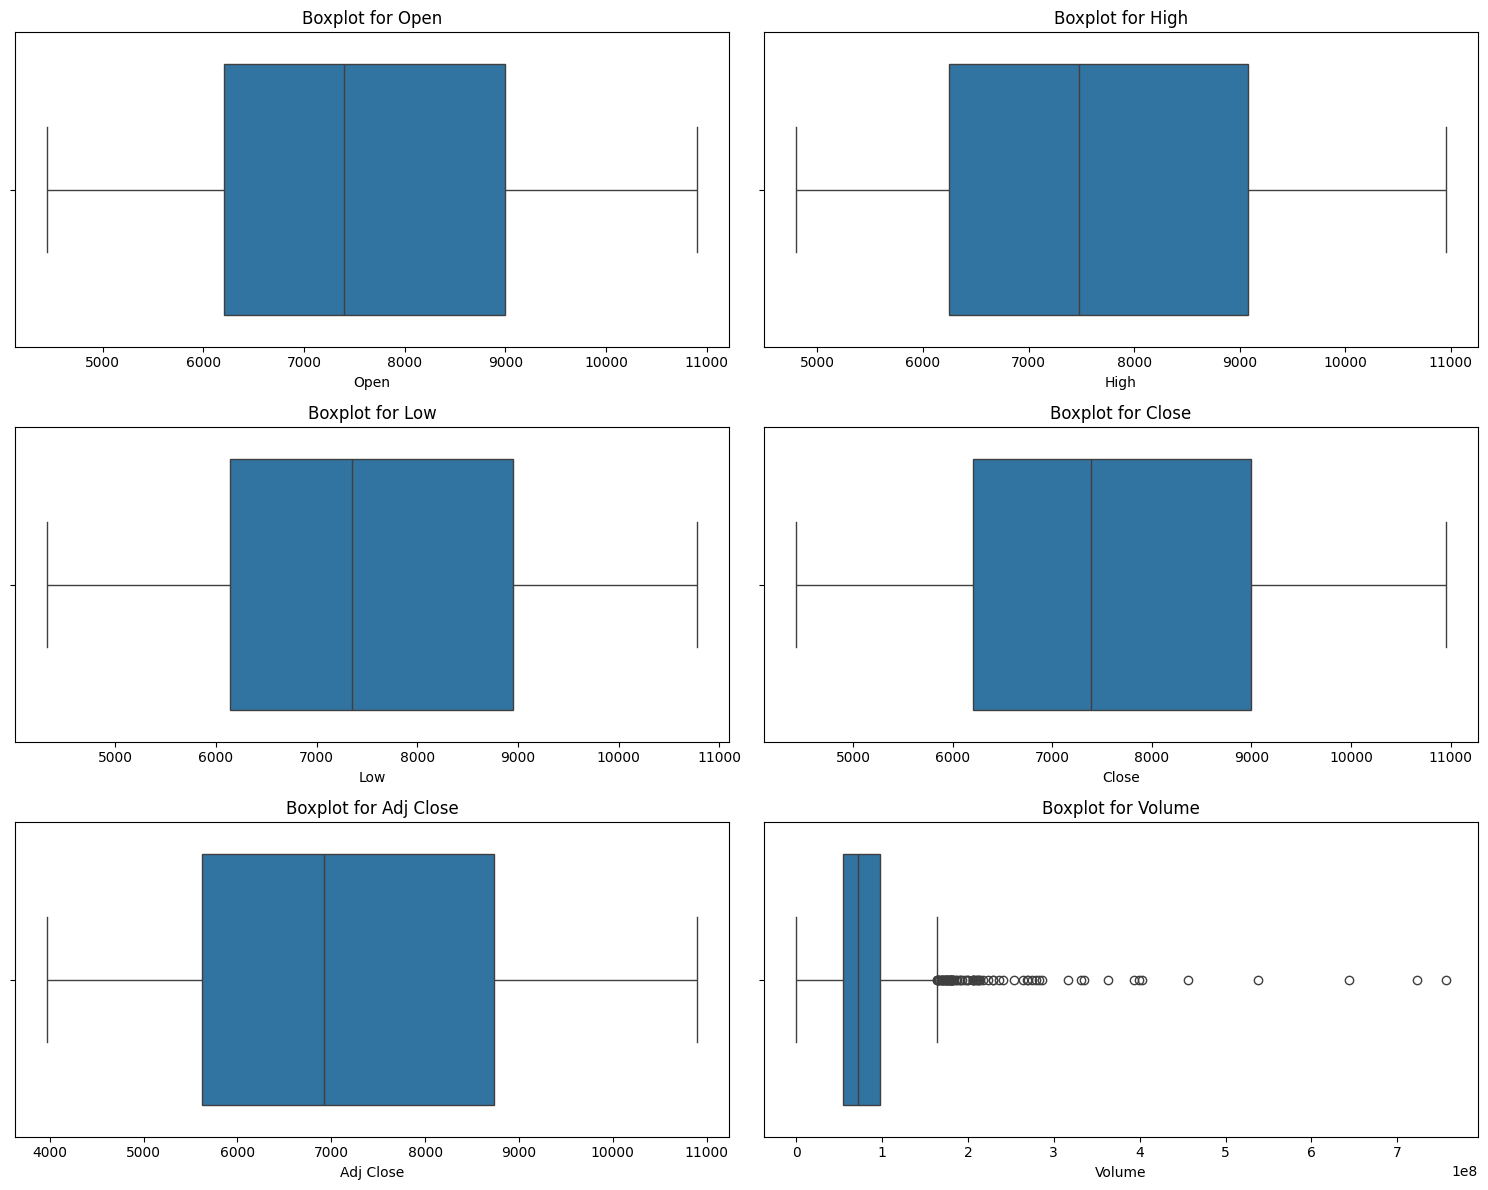

In [150]:
numerical_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
# Membuat subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
axes = axes.flatten()  # Flatten agar mudah diakses

# Plot setiap kolom
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Boxplot for {col}")

# Hapus subplot kosong jika jumlah kolom ganjil
if len(numerical_cols) < len(axes):
    for j in range(len(numerical_cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Terlihat pada fitur `volume` memiliki outlier. Selanjutnya mengidentifikasi jumlah outlier pada fitur `volume` dengan IQR.

In [151]:
# Menghitung IQR
q1 = df['Volume'].quantile(0.25)
q3 = df['Volume'].quantile(0.75)
iqr = q3 - q1

# Batas bawah dan atas
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Deteksi outlier
outliers = df[(df['Volume'] < lower_bound) | (df['Volume'] > upper_bound)]
print("Jumlah outlier pada Volume:", len(outliers))


Jumlah outlier pada Volume: 75


####  Pengecekan Urutan Time Series

In [152]:
# Menghitung jarak antar-tanggal
date_diff_table = date_diff.value_counts().reset_index()
date_diff_table.columns = ['Days Difference', 'Count']

# Menampilkan tabel
print(date_diff_table)


   Days Difference  Count
0              1.0   1153
1              3.0    287
2              2.0     22
3              4.0     17
4              5.0     10
5              6.0      5
6             11.0      2
7              8.0      1


## 3. Exploratory Data Analysis

Selanjutnya melakukan proses EDA

### 3.1 Descriptive Analysis

In [153]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1498.000000,1498.000000,1498.000000,1498.000000,1498.000000,1.498000e+03
mean,7592.787049,7659.202270,7524.506008,7591.104806,7166.814004,8.329055e+07
std,1582.951968,1591.154264,1579.617445,1585.884345,1752.662514,5.447070e+07
min,4450.000000,4800.000000,4325.000000,4430.000000,3973.115234,0.000000e+00
25%,6200.000000,6250.000000,6140.000000,6200.000000,5624.607300,5.388572e+07
50%,7400.000000,7475.000000,7350.000000,7387.500000,6924.654785,7.197850e+07
75%,9000.000000,9075.000000,8950.000000,9000.000000,8730.200928,9.790908e+07
max,10900.000000,10950.000000,10775.000000,10950.000000,10895.657227,7.564316e+08


Berdasarkan data tersebut, terdapat nilai minimum pada kolom Volume yang bernilai 0. Hal ini bisa disebabkan oleh dua kemungkinan. Pertama, bisa terjadi missing value. Kedua, saham memang tidak diperdagangkan pada tanggal tersebut karena berbagai alasan, seperti hari libur pasar, suspensi perdagangan, atau faktor lainnya. Untuk mengetahuinya akan dilakukan visualisasi fitur lainnya pada data dengan volume bernilai 0.

In [154]:
df[df.Volume == 0]

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-01,5200.0,5200.0,5200.0,5200.0,4606.876953,0
25,2019-02-05,5500.0,5500.0,5500.0,5500.0,4872.659668,0
47,2019-03-07,5490.0,5490.0,5490.0,5490.0,4863.799316,0
66,2019-04-03,5500.0,5500.0,5500.0,5500.0,4872.659668,0
76,2019-04-17,5495.0,5495.0,5495.0,5495.0,4868.229004,0
78,2019-04-19,5625.0,5625.0,5625.0,5625.0,4983.400879,0
86,2019-05-01,5750.0,5750.0,5750.0,5750.0,5140.710938,0
107,2019-05-30,5740.0,5740.0,5740.0,5740.0,5131.770020,0
109,2019-06-03,5820.0,5820.0,5820.0,5820.0,5203.292969,0
110,2019-06-04,5820.0,5820.0,5820.0,5820.0,5203.292969,0


Berdasarkan tabel di atas, pada tanggal tertentu `Open`, `High`, `Low` dan `Close` tidak bergerak sama sekali yang mengindikasikan bahwa pada tanggal tersebut saham tidak diperdagangkan. Hal ini juga menunjukkan bahwa tidak terdapat missing value pada kolom `Volume`.

### 3.2 Open and Close Prices of All Time

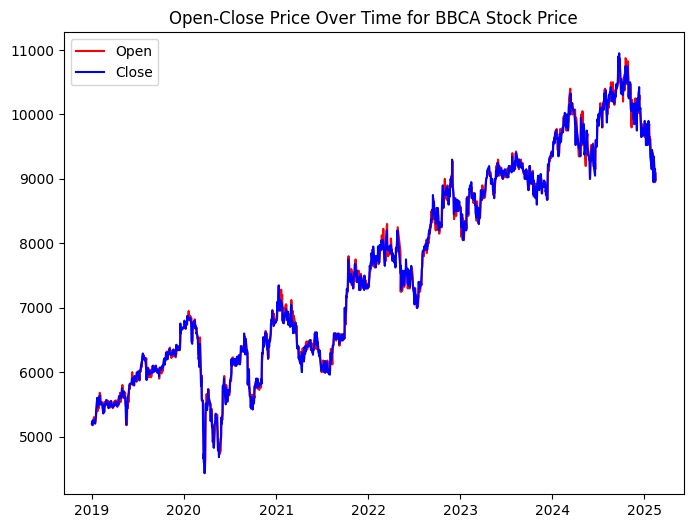

In [155]:
plt.figure(figsize=(8,6))
plt.plot(df['Date'], df['Open'], label='Open', color='red')
plt.plot(df['Date'], df['Close'], label='Close', color='blue')
plt.title('Open-Close Price Over Time for BBCA Stock Price')
plt.legend()

plt.show()


Berdasarkan data tersebut, dapat diamati bahwa harga saham BBCA cenderung mengalami kenaikan tiap tahunnya dan membentuk pola tertentu. Pola ini nantinya dapat dipelajari oleh model deep learning untuk membuat prediksi yang lebih akurat di masa depan.

### 3.3 Trading Volume of All Time

Volume merupakan jumlah total saham yang diperdagangkan dalam satu hari. Hal ini berpengaruh dalam menentukan likuiditas pasar, di mana likuiditas yang tinggi menunjukkan bahwa saham tersebut mudah diperdagangkan tanpa menyebabkan perubahan harga yang signifikan.

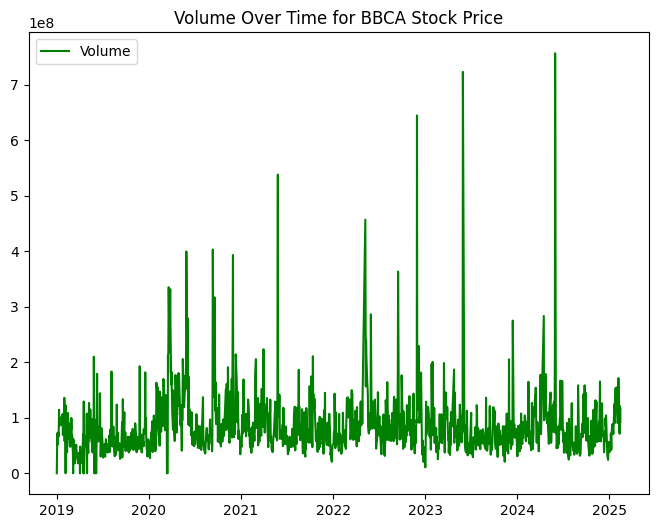

In [156]:
plt.figure(figsize=(8,6))
plt.plot(df['Date'], df['Volume'], label='Volume', color='green')
plt.title('Volume Over Time for BBCA Stock Price')
plt.legend()
plt.show()

Volume saham yang diperdagangkan cenderung konsisten tiap tahunnya mengindikasikan bahwa saham tersebut memiliki likuiditas yang stabil. Likuiditas yang konsisten menandakan bahwa saham tersebut dapat diperdagangkan dengan mudah oleh investor tanpa menyebabkan perubahan harga yang signifikan, yang merupakan tanda pasar yang sehat dan aktif, meskipun volume saham melonjak cukup tinggi pada periode tertentu.

### 3.4 Yearly Average Movement of Close Feature

**Close** merupakan harga penutupan saham pada akhir hari perdagangan. Harga ini sering digunakan sebagai acuan dalam analisis teknis dan keputusan trading karena mencerminkan nilai terakhir dari saham pada hari tersebut, yang biasanya dianggap lebih penting daripada harga lainnya dalam sehari. Pada tahap ini dilakukan visualisasi tren fitur (Close) di tiap tahunnya.

In [157]:
df_plot = df.copy()

In [158]:
df_plot['year'] = df_plot.Date.dt.year
df_plot['month'] = df_plot.Date.dt.month

C:\Users\Jals\AppData\Local\Temp\ipykernel_27880\4162995433.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')  # You can choose any colormap you prefer
C:\Users\Jals\AppData\Local\Temp\ipykernel_27880\4162995433.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.text(df_plot.loc[df_plot.year==y, :].shape[0]+0.1, df_plot.loc[df_plot.year==y, 'Close'][-1:].values[0], y, fontsize=12, color=colors[i])


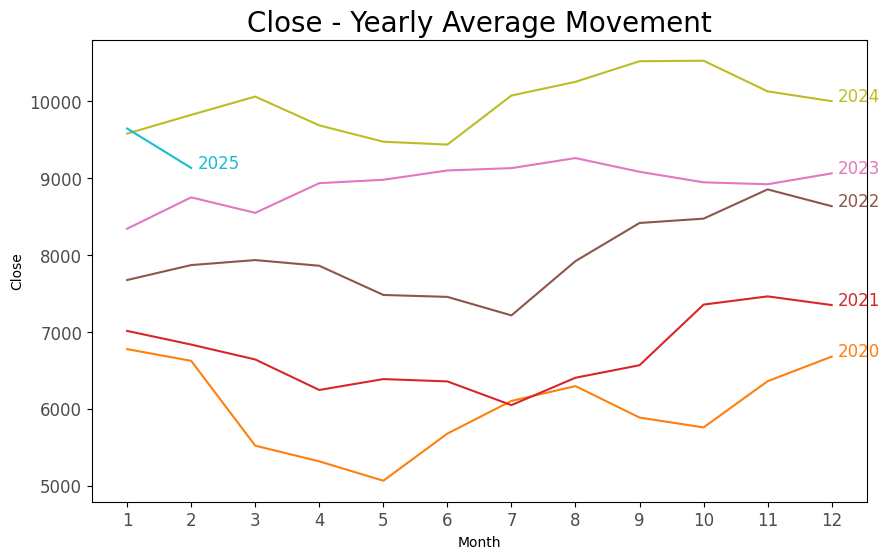

In [159]:
# Defining colors palette
np.random.seed(42)
df_plot = df_plot[['month', 'year', 'Close']].groupby(['month', 'year']).mean()[['Close']].reset_index()
years = df_plot['year'].unique()
cmap = cm.get_cmap('tab10')  # You can choose any colormap you prefer
colors = cmap(np.linspace(0, 1, len(years)))

# Plot
plt.figure(figsize=(10,6))
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'Close', data=df_plot[df_plot['year'] == y],color=colors[i], label=y)
        if y == 2018:
            plt.text(df_plot.loc[df_plot.year==y, :].shape[0]+0.3, df_plot.loc[df_plot.year==y, 'Close'][-1:].values[0], y, fontsize=12, color=colors[i])
        else:
            plt.text(df_plot.loc[df_plot.year==y, :].shape[0]+0.1, df_plot.loc[df_plot.year==y, 'Close'][-1:].values[0], y, fontsize=12, color=colors[i])

# Setting labels
plt.gca().set(ylabel= 'Close', xlabel = 'Month')
plt.xticks(ticks=range(1, 13), labels=range(1, 13), fontsize=12, alpha=0.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title("Close - Yearly Average Movement", fontsize=20)
plt.ylabel('Close')
plt.xlabel('Month')
plt.show()

Berdasarkan plot di atas, dapat dilihat bahwa pergerakan saham cenderung memiliki pola tertentu dan cukup konsisten tiap tahunnya. Meskipun terdapat fluktuasi bulanan, saham cenderung menunjukkan tren kenaikan dari tahun ke tahun.

### 3.5 Numerical Feature Correlation
Selanjutnya, analisis *feature correlation* akan dilakukan untuk memahami hubungan antara fitur-fitur dalam data. Visualisasi hubungan antar fitur akan dilakukan menggunakan pair plot, dan matriks korelasi akan dihitung untuk memperoleh gambaran menyeluruh tentang hubungan antar seluruh fitur numerik.

<Figure size 800x600 with 0 Axes>

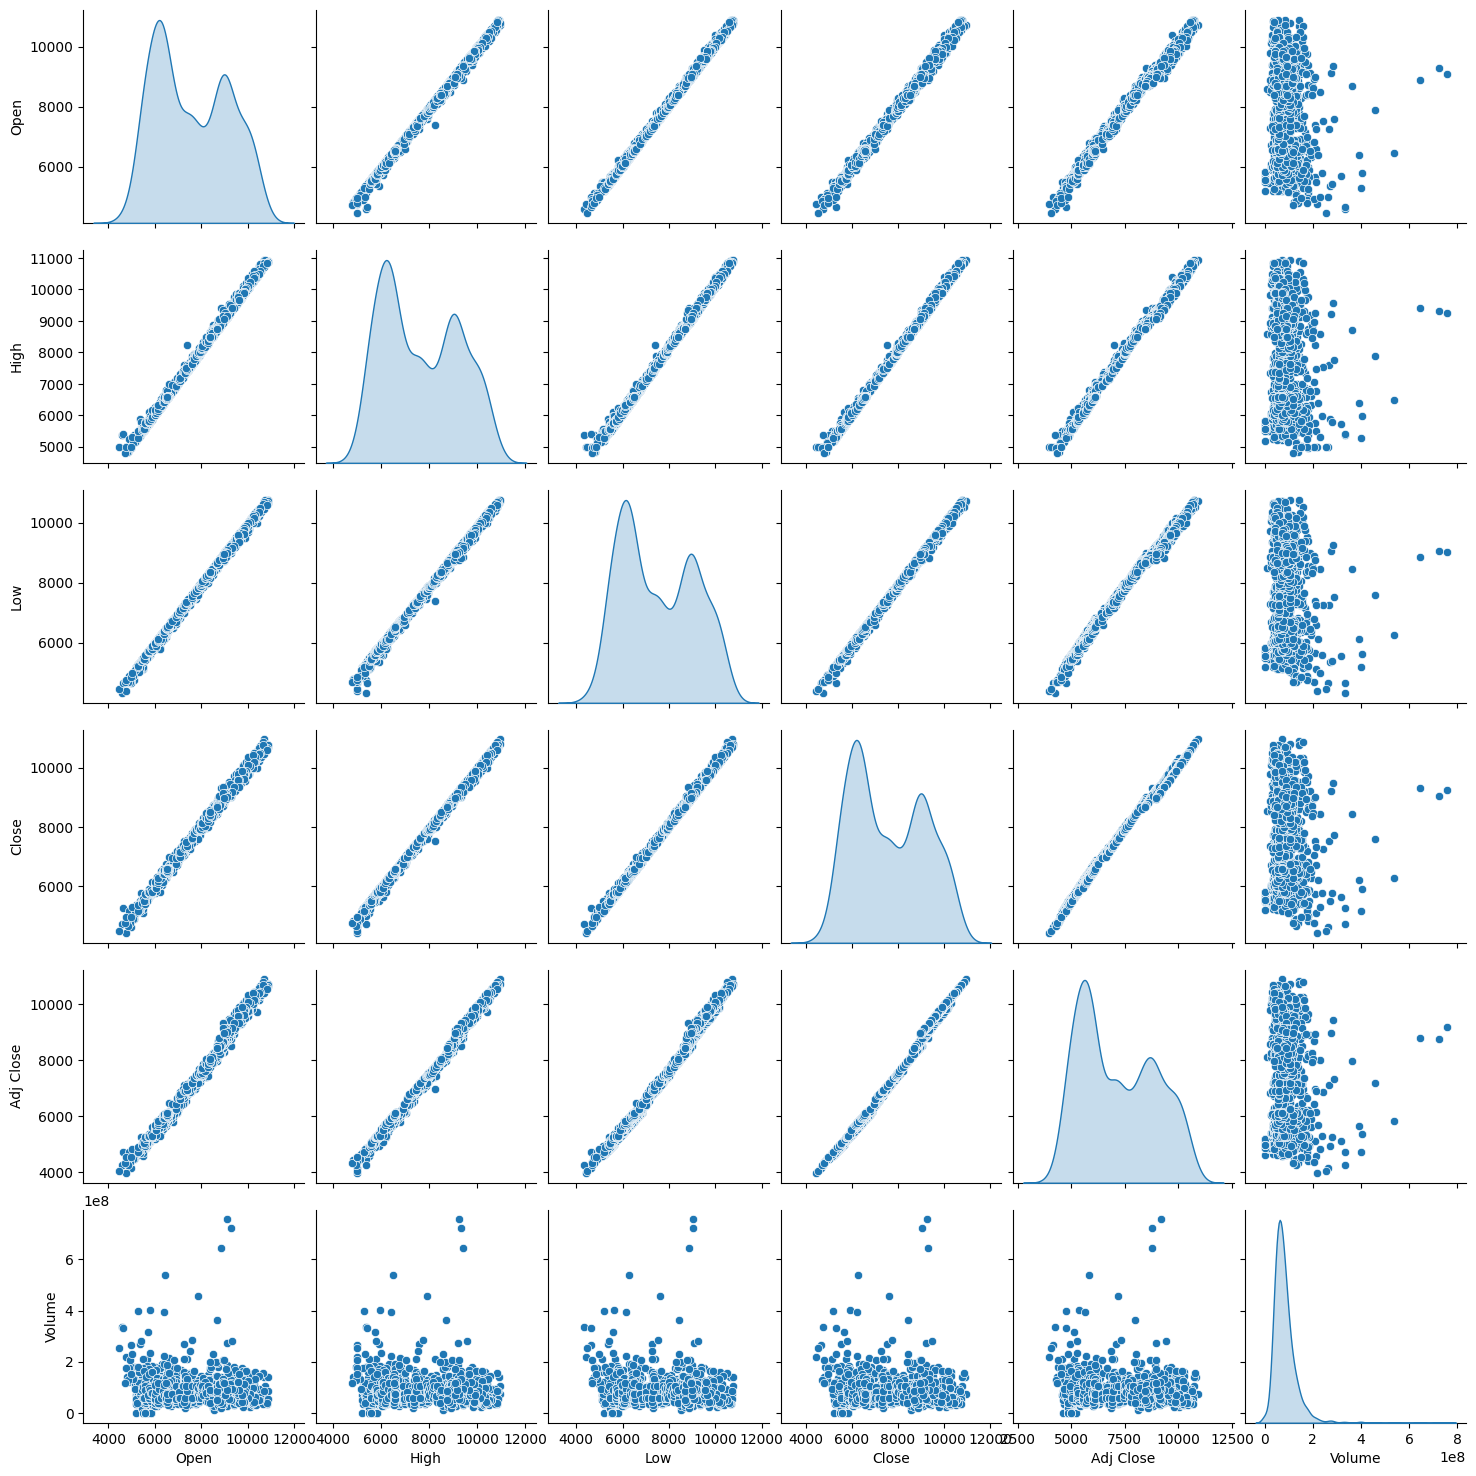

In [160]:
plt.figure(figsize=(8, 6))
sns.pairplot(df, diag_kind='kde')
plt.show()

Visualisasi di atas menunjukkan terdapat korelasi postif antar fitur `Open`, `High`, `Low`, `Close`, `Adj. Close`. Selanjutnya menghitung korelasi matrix.

C:\Users\Jals\AppData\Local\Temp\ipykernel_27880\3541350037.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


Text(0.5, 1.0, 'Matriks Korelasi untuk Fitur Numerik ')

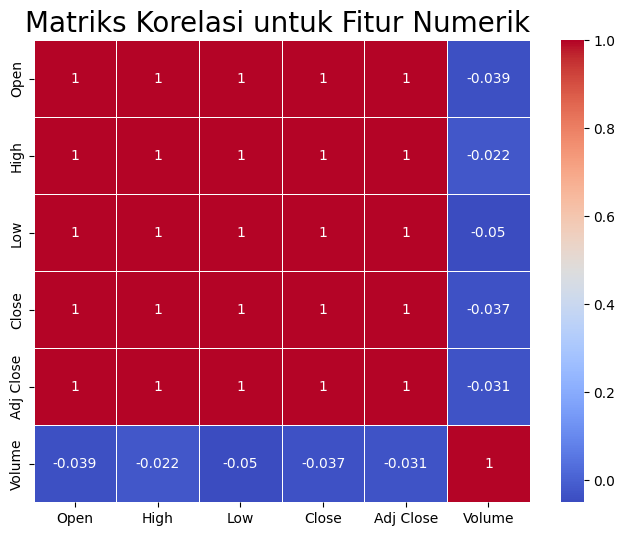

In [161]:
plt.figure(figsize=(8,6))
correlation_matrix = df.corr()

sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title(f"Matriks Korelasi untuk Fitur Numerik ", size=20)

Sama seperti visualisasi sebelumnya, korelasi antar fitur `Open`, `High`, `Low`, `Close`, `Adj. Close` **bernilai 1** yang menunjukkan korelasi positif sempurna.

## 4. Data Preparation

### 4.1 Feature Selection

Berdasarkan hasil analisis, fitur `Open`, `High`, `Low`, `Close`, `Adj. Close` berkorelasi positif sempurna yang berarti satu perubahan akan saling memengaruhi, maka pada tahap ini salah satu fitur tersebut akan dipilih untuk digunakan dalam model. Dalam hal ini, fitur `Close` akan digunakan.

In [162]:
df['Close'].head()

0    5200.0
1    5240.0
2    5180.0
3    5205.0
4    5245.0
Name: Close, dtype: float64

In [163]:
stock_close = df['Close'].values

In [164]:
stock_close

array([5200., 5240., 5180., ..., 9150., 9000., 8975.])

### 4.2 Standarisasi Data

Data dinormalisasi dengan metode standarisasi.

In [165]:
scaler = StandardScaler()
data = scaler.fit_transform(stock_close.reshape(-1,1))

### 4.3 Splitting Data to Train & Test

Pada tahap ini, data dibagi menjadi data pelatihan (train) dan data pengujian (test). Sebelum melakukannya, terlebih dahulu mendefinisikan variabel dan fungsi yang akan digunakan untuk pembagian data dan pembuatan *window*. *Window* ini merupakan sekumpulan data dalam interval waktu tertentu yang digunakan untuk membuat prediksi *time series*.

In [166]:
WINDOW_SIZE = 60
BATCH_SIZE = 32 
TRAIN_RATIO = 0.9

In [167]:
def create_windowed_features(data, window_size):
    X = []
    y = []
    for i in range(window_size, data.shape[0]):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [168]:
def split_features_and_target(df, train_ratio=TRAIN_RATIO, window_size=WINDOW_SIZE):
    train_data = df[:int(len(df) * train_ratio)]
    test_data = df[int(len(df) * train_ratio) - window_size:]
    print("Training data:", train_data.shape)
    print("Test data:", test_data.shape)
    X_train, y_train = create_windowed_features(train_data, window_size)
    X_test, y_test = create_windowed_features(test_data, window_size)

    return X_train, y_train, X_test, y_test

In [169]:
X_train, y_train, X_test, y_test = split_features_and_target(data)

Training data: (1348, 1)
Test data: (210, 1)


In [170]:
# After windowing or feature extraction step
print("Training features shape after windowing:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing features shape after windowing:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training features shape after windowing: (1288, 60, 1)
Training labels shape: (1288, 1)
Testing features shape after windowing: (150, 60, 1)
Testing labels shape: (150, 1)


## 5. Model Development

Pada tahap ini, model LSTM dan GRU dibangun dengan parameter yang sama. Berikut adalah konfigurasi model yang digunakan:
* EPOCHS : 20
* Hidden Layer : 128 unit
* Activation Function : Adam
* Look Back Value / Window : 60
* Dropout : 0.2

### 5.1 LSTM

In [171]:
model_lstm = keras.models.Sequential()
model_lstm.add(keras.layers.LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(keras.layers.Dense(units=128, activation='relu'))
model_lstm.add(keras.layers.LSTM(units=64, return_sequences=False))
model_lstm.add(keras.layers.Dropout(0.2))
model_lstm.add(keras.layers.Dense(units=1))

In [172]:
model_lstm.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 60, 64)            16896     
                                                                 
 dense_18 (Dense)            (None, 60, 128)           8320      
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 74,689
Trainable params: 74,689
Non-trainable params: 0
_________________________________________________________________


In [173]:
model_lstm.compile(optimizer='adam', 
              loss='mae',
              metrics=keras.metrics.RootMeanSquaredError())

In [174]:
history_lstm = model_lstm.fit(X_train, y_train, 
               epochs=20, 
               batch_size=32,
               validation_data=(X_test, y_test))

Epoch 1/20
41/41 [==============================] - 9s 101ms/step - loss: 0.2218 - root_mean_squared_error: 0.3289 - val_loss: 0.2297 - val_root_mean_squared_error: 0.2661
Epoch 2/20
41/41 [==============================] - 3s 76ms/step - loss: 0.1157 - root_mean_squared_error: 0.1552 - val_loss: 0.1247 - val_root_mean_squared_error: 0.1502
Epoch 3/20
41/41 [==============================] - 4s 91ms/step - loss: 0.1116 - root_mean_squared_error: 0.1458 - val_loss: 0.1121 - val_root_mean_squared_error: 0.1403
Epoch 4/20
41/41 [==============================] - 4s 93ms/step - loss: 0.1053 - root_mean_squared_error: 0.1380 - val_loss: 0.1479 - val_root_mean_squared_error: 0.1757
Epoch 5/20
41/41 [==============================] - 3s 84ms/step - loss: 0.0968 - root_mean_squared_error: 0.1310 - val_loss: 0.1040 - val_root_mean_squared_error: 0.1315
Epoch 6/20
41/41 [==============================] - 4s 88ms/step - loss: 0.0974 - root_mean_squared_error: 0.1280 - val_loss: 0.1252 - val_root_

### 5.2 GRU

In [175]:
model_gru = keras.models.Sequential()

model_gru.add(keras.layers.GRU(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(keras.layers.Dense(units=128, activation='relu'))
model_gru.add(keras.layers.GRU(units=64, return_sequences=False))
model_gru.add(keras.layers.Dropout(0.2))
model_gru.add(keras.layers.Dense(units=1))

In [176]:
model_gru.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 60, 64)            12864     
                                                                 
 dense_20 (Dense)            (None, 60, 128)           8320      
                                                                 
 gru_9 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 58,497
Trainable params: 58,497
Non-trainable params: 0
_________________________________________________________________


In [177]:
model_gru.compile(optimizer='adam', 
              loss='mae',
              metrics=keras.metrics.RootMeanSquaredError())

In [178]:
history_gru = model_gru.fit(X_train, y_train, 
               epochs=20,
               batch_size=32,
               validation_data=(X_test, y_test))

Epoch 1/20
41/41 [==============================] - 9s 96ms/step - loss: 0.1704 - root_mean_squared_error: 0.2570 - val_loss: 0.0844 - val_root_mean_squared_error: 0.1051
Epoch 2/20
41/41 [==============================] - 3s 69ms/step - loss: 0.0892 - root_mean_squared_error: 0.1162 - val_loss: 0.0761 - val_root_mean_squared_error: 0.0962
Epoch 3/20
41/41 [==============================] - 3s 67ms/step - loss: 0.0889 - root_mean_squared_error: 0.1173 - val_loss: 0.0737 - val_root_mean_squared_error: 0.0936
Epoch 4/20
41/41 [==============================] - 2s 51ms/step - loss: 0.0799 - root_mean_squared_error: 0.1070 - val_loss: 0.1186 - val_root_mean_squared_error: 0.1390
Epoch 5/20
41/41 [==============================] - 2s 53ms/step - loss: 0.0830 - root_mean_squared_error: 0.1091 - val_loss: 0.1111 - val_root_mean_squared_error: 0.1306
Epoch 6/20
41/41 [==============================] - 2s 58ms/step - loss: 0.0794 - root_mean_squared_error: 0.1042 - val_loss: 0.0913 - val_root_m

## 6. Evaluasi Model

### 6.1 Compare train loss and validation loss

In [179]:
def plot_loss(history, model_name, ax):
    ax.plot(history.history['loss'], label='Train Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title(f'{model_name} Model Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

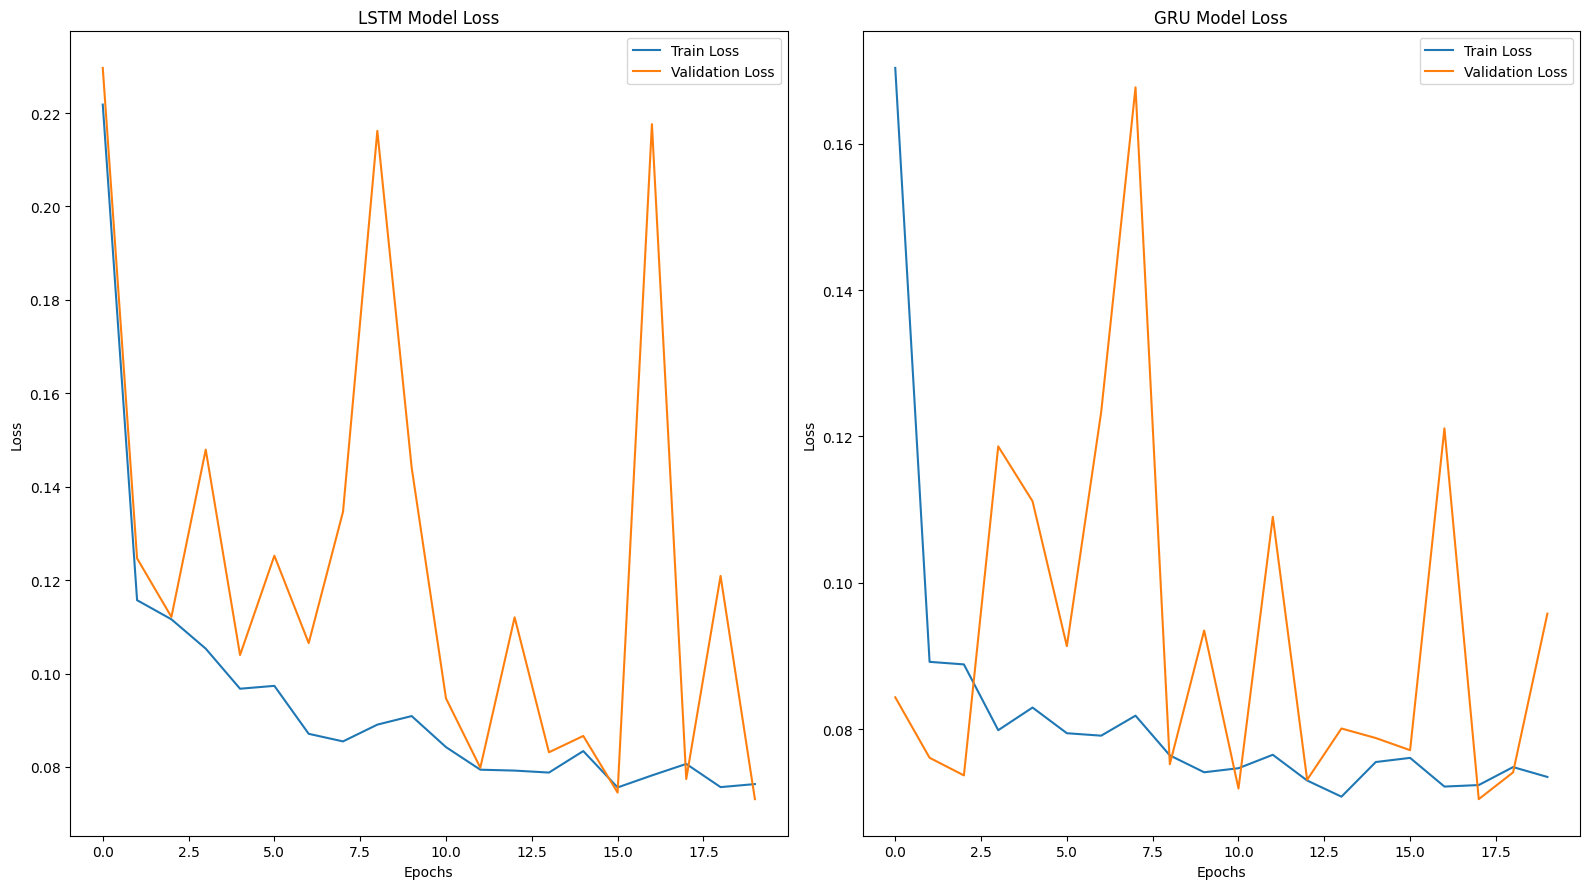

In [180]:
# Membuat dua plot loss secara berdampingan
fig, axs = plt.subplots(1, 2, figsize=(16, 9))
plot_loss(history_lstm, 'LSTM', axs[0])
plot_loss(history_gru, 'GRU', axs[1])
plt.tight_layout()
plt.show()


### 6.2 Compare prediction vs test data

#### 6.2.1 Predict the Data

In [181]:
def prediction(model,data):
    prediction = model.predict(data)
    prediction = scaler.inverse_transform(prediction)
    return prediction

In [182]:
predictions_lstm = prediction(model_lstm, X_test)
predictions_gru = prediction(model_gru, X_test)

5/5 [==============================] - 1s 27ms/step


#### 6.2.2 Plotting Prediction Result

In [183]:
def plot_future(prediction, model_name, ax, start_date = '2024-01-01'):
        train_data = df[:int(len(df) * TRAIN_RATIO)]
        test_data = df[int(len(df) * TRAIN_RATIO):]

        ax.plot(train_data['Date'][train_data.Date >= start_date], 
                train_data['Close'][train_data.Date >= start_date], 
                label='Train (Actual)', 
                color='blue')
        ax.plot(test_data['Date'], test_data['Close'], label='Test (Actual)', color='green')
        ax.plot(test_data['Date'], prediction, label=f'{model_name} (Predictions)', color='orange')
        ax.set_title(f'Prediction vs Test data {model_name} Model')
        ax.set_xlabel('Date')
        ax.set_ylabel('Close Price')
        ax.legend()

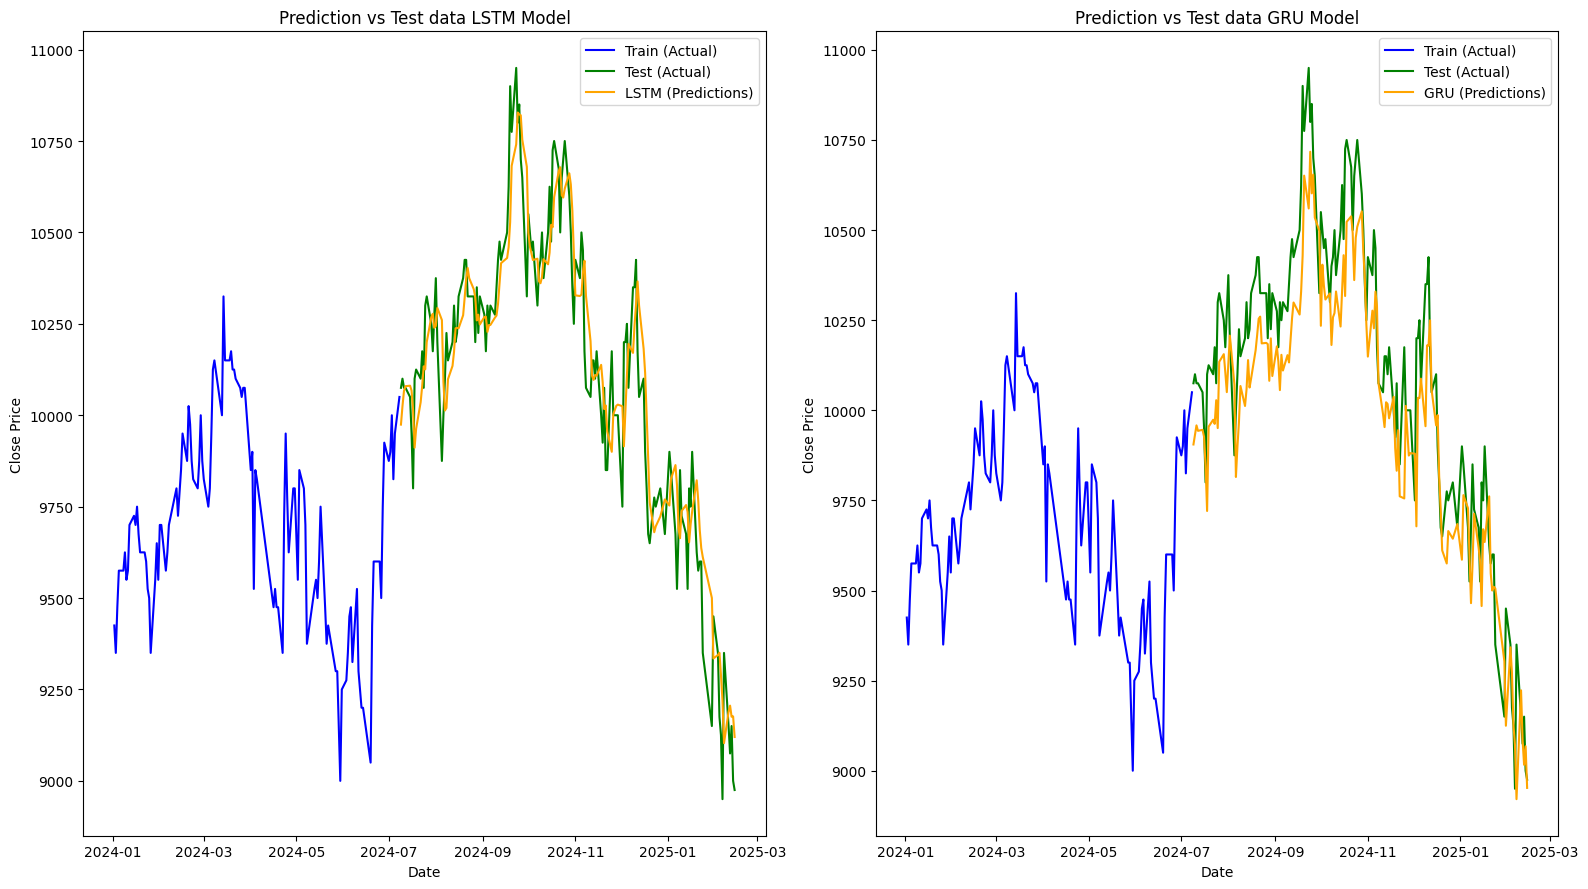

In [184]:
# Membuat dua plot loss secara berdampingan
fig, axs = plt.subplots(1, 2, figsize=(16, 9))
plot_future(predictions_lstm, 'LSTM', axs[0])
plot_future(predictions_gru, 'GRU', axs[1])
plt.tight_layout()
plt.show()

### 6.3 Compare Evaluation Metric 

In [185]:
def evaluate_prediction(predictions, actual, model_name,df):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / actual)) * 100
    rsmpe = np.sqrt(np.mean((errors / actual) ** 2)) * 100
    
    df = df.append({
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'RSMPE': rsmpe
    }, ignore_index=True)
    return df

In [186]:
y_test_inversed = scaler.inverse_transform(y_test)

In [187]:
evaluation_df = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'MAPE', 'RSMPE'])

In [188]:
evaluation_df = evaluate_prediction(predictions_lstm, y_test_inversed, 'LSTM', evaluation_df)
evaluation_df = evaluate_prediction(predictions_gru, y_test_inversed, 'GRU', evaluation_df)
evaluation_df.set_index('Model', inplace=True)
evaluation_df

C:\Users\Jals\AppData\Local\Temp\ipykernel_27880\821411194.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
C:\Users\Jals\AppData\Local\Temp\ipykernel_27880\821411194.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


,MAE,RMSE,MAPE,RSMPE
Model,,,,
LSTM,115.901986,142.498071,1.155501,1.429488
GRU,151.862852,186.951058,1.489320,1.826261
